### 데이터준비

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents = True, exist_ok = True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists() :
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)
    

In [2]:
# 텍스트 이외의 자료형을 파일로 저장하기 위하여 pickle 사용
# 데이터를 직렬화하기 위해 사용
import pickle
#gzip 모듈은 open(), compress() 및 decompress() 편리 함수뿐만 아니라 GzipFile 클래스도 제공합니다.
#GzipFile 클래스는 gzip-형식 파일을 읽고 쓰는데, 자동으로 데이터를 압축하거나 압축을 풀어서 일반적인 파일 객체처럼 보이게 합니다.
import gzip 

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


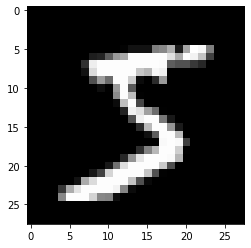

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch 

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn 사용 없이 신경망 생성

In [5]:
import math

weight = torch.randn(784, 10) / math.sqrt(784) # 가중치 초기화 방법으로 weight initialization 를 사용
weight.requires_grad_()
bias = torch.zeros(10, requires_grad = True)

In [6]:
def log_softmax(x) :
    return x - x.exp().sum(-1).log().unsqueeze(-1)

# @ 행렬곱셈 연산의미
def model(xb) :
    return log_softmax(xb @ weight + bias)

In [7]:
bs = 64  # 배치 크기

xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출
preds = model(xb)  # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.3770, -2.9994, -1.6751, -2.8987, -2.3696, -1.9591, -2.5774, -2.9274,
        -2.4695, -1.7937], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [8]:
# 손실함수를 사용하기 위한 음의 로그 우도를 구현 

def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [9]:
# 손실 파악 
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3473, grad_fn=<NegBackward>)


In [10]:
# 모델 정확도 계산 

def accuracy(out, yb) :
    preds = torch.argmax(out, dim = 1)
    return (preds == yb).float().mean()

In [11]:
print(accuracy(preds, yb))

tensor(0.0625)


#### 훈련루프 실행 

* 데이터의 미니배치를 선택 (bs 크기)
* 모델을 이용하여 예측 수행
* 손실 계산
* loss.backward() 를 이용하여 모델의 기울기 업데이트, 이 경우에 weights 와 bias.

이 기울기들을 이용하여 가중치와 절편을 업데이트 합니다. 우리는 이것을 torch.no_grad() 컨텍스트 매니져(context manager) 내에서 실행합니다, 왜냐하면 이러한 실행이 다음 기울기의 계산에 기록되지 않기를 원하기 때문입니다.


 기울기를 0으로 설정합니다, 그럼으로써 다음 루프(loop)에 준비하게 됩니다. 그렇지 않으면, 우리의 기울기들은 일어난 모든 연산의 누적 집계를 기록하게 되버립니다. (즉, loss.backward() 가 이미 저장된 것을 대체하기보단, 기존 값에 기울기를 더하게 됩니다).

In [13]:
# 매 단계마다 다양한 변수 값을 점검
from IPython.core.debugger import set_trace

lr = 0.5 # 학습률
epochs = 2 # 훈련에 사용할 에폭 수

for epoch in range(epochs) :
    for i in range( (n-1)// bs + 1) :
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weight -= weight.grad * lr
            bias -= bias.grad * lr
            weight.grad.zero_()
            bias.grad.zero_()

In [14]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0780, grad_fn=<NegBackward>) tensor(1.)


### torch.nn

In [17]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb) :
    return xb @ weight + bias

In [18]:
print(loss_func(model(xb), yb), accuracy(model (xb), yb))

tensor(0.0780, grad_fn=<NllLossBackward>) tensor(1.)


## nn.Module

In [23]:
 from torch import nn

class Mnist_Logistic(nn.Module) :
    def __init__ (self) :
        super().__init__()
        self.weight = nn.Parameter(torch.randn(784, 10)/ math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self , xb) :
        return xb @ self.weight + self.bias

In [24]:
# 함수 대신 object사용하기 때문에 모델 instantiate 

model = Mnist_Logistic()

In [26]:
print(loss_func(model(xb), yb))

tensor(2.2158, grad_fn=<NllLossBackward>)
